# A Deep-Dive on the Effects of Head Coaching Changes in the NBA

## Introduction

The purpose of this project is to investigate the impact of head coach changes on underperforming NBA teams. In the NBA, head coaches are at the forefront of critique when a team underperforms. This usually results in a change of head coaching and, sometimes, the entire coaching staff; but, how effective is this strategy? This project aims to analyze the tangible effects of such coaching transitions on team performance in the subsequent seasons. My focus is on providing a data-driven exploration of the role head coaches play in the NBA and how these changes may influence the team's future performance.

At the end of the 2022-2023 regular season, the Toronto Raptors placed 9th in the Eastern Conference Standings, marking their 2nd missed playoffs in the 3 seasons subsequent to their 2019 Championship run. This led the Raptors parting ways with head coach Nick Nurse as well with the majority of the coaching staff in the summer of 2023. This season, the Raptors hired Darko Rajakovic, an assistant coach from the Memphis Grizzlies to be their new head coach to implement new systems, offensive and defensive philosophies, and to facilitate development of the young Toronto Raptors core.

Coming off high anticipation after the offseason, the Toronto Raptors are 2-4 to start the season. This raises the question: What level of impact can we relaistically expect from these coaching changes? This scenario provides a real-world backdrop for our comprehensive investigation intot he effects of coaching transitions across the NBA.

We seek to answer several questions through exploratory data analysis (EDA):

What is the average number of playoffs clinched within the first 3 years by teams that undergo head coaching changes? How does changing the head coach correlate with the average change in team win percentage in subsequent years? We will also delve into predictive modeling using neural networks (NN). The NN will help us predict the team's future win percentage and determine which seed they could potentially secure in their respective conference. Furthermore, we aim to predict the winningness of the team in subsequent years based on their regular-season records. These predictions will be categorized into:

- High seed team (1-4)
- Low seed team (5-8)
- Out of playoff contention

We can also measure a team's winningness by measuring playoff performance, predicting whether they will:

- Win a championship
- Clinch the conference finals
- Clinch the playoffs

Through this project, we aim to provide data-driven insights into the impact of coaching changes on NBA teams and their future performance, shedding light on the strategies employed in the dynamic world of professional basketball.

## Data Sources

This project uses [Swar's NBA API](https://github.com/swar/nba_api) for the acquisition of data accessible through https://stats.nba.com.

## Collecting the Data

In this section I'll be using the API to collect the data and construct the reporting table.  

In [242]:
# Importing libraries and API endpoints

import pandas as pd
from nba_api.stats.endpoints import commonteamroster
from nba_api.stats.static import teams
from nba_api.stats.endpoints import playoffpicture
from nba_api.stats.endpoints import teamdetails

import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt


In [262]:
# Get a list of team info
team_info = teams.get_teams()
head_coaches_data = []

# Iterate through teams and seasons
for team in team_info:
    team_id = team['id']
    team_name = team['abbreviation']
    for season in range(2005, 2024):
        coach_data = commonteamroster.CommonTeamRoster(team_id=team_id, season=season)
        coach_data_df = coach_data.coaches.get_data_frame()
        seasons = f"{season}-{str(season+1)[-2:]}"
        if not coach_data_df.empty:
            try:
                coach_name = coach_data_df[coach_data_df['COACH_TYPE'] == 'Head Coach']['COACH_NAME'].values[0]
            except IndexError:
                coach_name = 'None'
        head_coaches_data.append({
            'Team ID': team_id,
            'Season': seasons,
            'Team': team_name,
            'Coach': coach_name
        })

head_coaches_df = pd.DataFrame(head_coaches_data)

In [10]:
# finding no data instances - data isn't really clean 
no_data = head_coaches_df[head_coaches_df['Coach'] == 'None']
no_data

,Team ID,Season,Team,Coach
63,1610612740,2014-15,NOP,None
115,1610612743,2012-13,DEN,None
190,1610612747,2015-16,LAL,None
331,1610612755,2012-13,PHI,None
355,1610612756,2018-19,PHX,None
388,1610612758,2015-16,SAC,None
423,1610612760,2014-15,OKC,None
538,1610612766,2021-22,CHA,None


In [335]:
playoff_picture_df = pd.DataFrame(columns=['Season', 'Seed', 'Team ID', 'Wins', 'Losses', 'Win PCT', 'Clinched Playoffs', 'Clinched Conference'])

for season in range(2005, 2024):
    playoff_picture = playoffpicture.PlayoffPicture(season_id='2' + str(season))

    EastConfStandings_df = playoff_picture.east_conf_standings.get_data_frame()
    EastConfPlayoffPicture_df = playoff_picture.east_conf_playoff_picture.get_data_frame()
    east_team_wins = EastConfStandings_df['WINS']
    east_team_losses = EastConfStandings_df['LOSSES']
    east_team_seed = EastConfPlayoffPicture_df['HIGH_SEED_RANK'].combine_first(EastConfPlayoffPicture_df['LOW_SEED_RANK'])
    east_team_pct = EastConfStandings_df['PCT']
    #east_team = EastConfStandings_df['TEAM']
    east_team_id = EastConfStandings_df['TEAM_ID']
    east_team_clinched_playoffs = EastConfStandings_df['CLINCHED_PLAYOFFS']
    east_team_clinched_conference = EastConfStandings_df['CLINCHED_CONFERENCE']

    east_df = pd.DataFrame({
        'Season': f"{season}-{str(season+1)[-2:]}",
        'Team ID': east_team_id,
        'Wins': east_team_wins,
        'Losses': east_team_losses, 
        'Win PCT': east_team_pct,
        'Clinched Playoffs': east_team_clinched_playoffs,
        'Clinched Conference': east_team_clinched_conference
        })
    
    WestConfStandings_df = playoff_picture.west_conf_standings.get_data_frame()
    WestConfPlayoffPicture_df = playoff_picture.west_conf_playoff_picture.get_data_frame()
    west_team_wins = WestConfStandings_df['WINS']
    west_team_losses = WestConfStandings_df['LOSSES']
    west_team_pct = WestConfStandings_df['PCT']
    #west_team = WestConfStandings_df['TEAM']
    west_team_id = WestConfStandings_df['TEAM_ID']
    west_team_clinched_playoffs = WestConfStandings_df['CLINCHED_PLAYOFFS']
    west_team_clinched_conference = WestConfStandings_df['CLINCHED_CONFERENCE']

    west_df = pd.DataFrame({
        'Season': f"{season}-{str(season+1)[-2:]}",
        'Team ID': west_team_id,
        'Wins': west_team_wins,
        'Losses': west_team_losses, 
        'Win PCT': west_team_pct,
        'Clinched Playoffs': west_team_clinched_playoffs,
        'Clinched Conference': west_team_clinched_conference
        })
    east_df.reset_index(drop=True, inplace=True)
    west_df.reset_index(drop=True, inplace=True)

    east_df['Seed'] = east_df.index + 1
    west_df['Seed'] = west_df.index + 1

    playoff_picture_df = pd.concat([playoff_picture_df, east_df, west_df])

playoff_picture_df

/var/folders/3z/8j8g_lgs5j7b31l1sp39n6380000gn/T/ipykernel_67037/1249752408.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  playoff_picture_df = pd.concat([playoff_picture_df, east_df, west_df])


,Season,Seed,Team ID,Wins,Losses,Win PCT,Clinched Playoffs,Clinched Conference
0,2005-06,1,1610612765,64,18,0.780,1,1
1,2005-06,2,1610612748,52,30,0.634,1,0
2,2005-06,3,1610612739,50,32,0.610,1,0
3,2005-06,4,1610612751,49,33,0.598,1,0
4,2005-06,5,1610612764,42,40,0.512,1,0
...,...,...,...,...,...,...,...,...
10,2023-24,11,1610612757,3,5,0.375,0,0
11,2023-24,12,1610612746,3,6,0.333,0,0
12,2023-24,13,1610612759,3,7,0.300,0,0
13,2023-24,14,1610612762,3,7,0.300,0,0


In [ ]:
data = []
teams = teams.get_teams()
team_id = [team['id'] for team in teams]
all_seasons = [f"{year - 1}-{str(year)[-2:]}" for year in range(2005, 2024)]

for id in team_id:
    champ = teamdetails.TeamDetails(team_id=id)
    champ_df = champ.team_awards_championships.get_data_frame()
    
    if 'YEARAWARDED' in champ_df:
        won_titles = champ_df[champ_df['YEARAWARDED'] >= 2005]
        if not won_titles.empty:
            seasons = won_titles['YEARAWARDED'].apply(lambda year: f"{year - 1}-{str(year)[-2:]}")
            data.extend([(id, season, 1) for season in seasons])

# Fill in missing entries with 0
for id in team_id:
    for season in all_seasons:
        if not any((entry[0] == id and entry[1] == season) for entry in data):
            data.append((id, season, 0))

title_df = pd.DataFrame(data, columns=['Team ID', 'Season', 'Won Title'])
title_df


,Team ID,Season,Won Title
0,1610612738,2007-08,1
1,1610612739,2015-16,1
2,1610612742,2010-11,1
3,1610612743,2022-23,1
4,1610612744,2014-15,1
...,...,...,...
565,1610612766,2018-19,0
566,1610612766,2019-20,0
567,1610612766,2020-21,0
568,1610612766,2021-22,0


: 

In [340]:
combined_df = pd.merge(head_coaches_df, playoff_picture_df, on=['Team ID', 'Season'], how='left')
combined_df = pd.merge(combined_df, title_df, how='left')
combined_df = combined_df.sort_values(by='Season')
combined_df

,Team ID,Season,Team,Coach,Seed,Wins,Losses,Win PCT,Clinched Playoffs,Clinched Conference,Won Title
0,1610612737,2005-06,ATL,Mike Woodson,14,26,56,0.317,0,0,0.0
437,1610612760,2005-06,OKC,Bob Hill,11,35,47,0.427,0,0,0.0
38,1610612739,2005-06,CLE,Mike Brown,3,50,32,0.610,1,0,0.0
418,1610612759,2005-06,SAS,Gregg Popovich,1,63,19,0.768,1,1,0.0
399,1610612758,2005-06,SAC,Rick Adelman,8,44,38,0.537,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
455,1610612760,2023-24,OKC,Mark Daigneault,6,5,4,0.556,0,0,NaN
474,1610612761,2023-24,TOR,Darko Rajakovic,11,4,5,0.444,0,0,NaN
493,1610612762,2023-24,UTA,Will Hardy,14,3,7,0.300,0,0,NaN
531,1610612764,2023-24,WAS,Wes Unseld Jr,14,2,7,0.222,0,0,NaN


## Feature Engineering

**v1 (Current)**
- Coach experience (YoE)
- Coach track record (W/L)
- Historical team performance (T-3 seasons average)

v2
- Player stats

In [341]:
# Creating a seed type for classification

seed_data = []

for seed in combined_df.Seed:
    if seed < 5: 
        seed_data.append(1) # seeds 1-4
    elif seed < 9: 
        seed_data.append(2) # seeds 5-8
    else:
        seed_data.append(3) # below 8th seed

combined_df['Seed Type'] = seed_data

In [349]:
num_prev_seasons = 3

combined_df_sortavg = combined_df.sort_values(by = ['Season', 'Team'])
combined_df['Avg Wins T-3 Seasons'] = combined_df_sortavg.groupby('Team')['Wins'].rolling(window=num_prev_seasons).mean().reset_index(0, drop=True)
combined_df['Avg Losses T-3 Seasons'] = combined_df_sortavg.groupby('Team')['Losses'].rolling(window=num_prev_seasons).mean().reset_index(0, drop=True)
combined_df['Avg Win PCT T-3 Seasons'] = combined_df_sortavg.groupby('Team')['Win PCT'].rolling(window=num_prev_seasons).mean().reset_index(0, drop=True)

combined_df['Wins'] = pd.to_numeric(combined_df['Wins'], errors='coerce')
combined_df['Losses'] = pd.to_numeric(combined_df['Losses'], errors='coerce')

,Team ID,Season,Team,Coach,Seed,Wins,Losses,Win PCT,Clinched Playoffs,Clinched Conference,Won Title,Seed Type,Avg Wins T-3 Seasons,Avg Losses T-3 Seasons,Avg Win PCT T-3 Seasons,Agg. Coach Wins,Agg. Coach Losses,Helper,New Coach,Coach Experience
0,1610612737,2005-06,ATL,Mike Woodson,14,26,56,0.317,0,0,0.0,3,NaN,NaN,NaN,26.0,56.0,1,True,1.0
1,1610612760,2005-06,OKC,Bob Hill,11,35,47,0.427,0,0,0.0,3,NaN,NaN,NaN,35.0,47.0,1,True,1.0
2,1610612739,2005-06,CLE,Mike Brown,3,50,32,0.610,1,0,0.0,1,NaN,NaN,NaN,50.0,32.0,1,True,1.0
3,1610612759,2005-06,SAS,Gregg Popovich,1,63,19,0.768,1,1,0.0,1,NaN,NaN,NaN,63.0,19.0,1,True,1.0
4,1610612758,2005-06,SAC,Rick Adelman,8,44,38,0.537,1,0,0.0,2,NaN,NaN,NaN,44.0,38.0,1,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,1610612760,2023-24,OKC,Mark Daigneault,6,5,4,0.556,0,0,NaN,2,23.000000,34.666667,0.445667,135.0,182.0,1,False,5.0
566,1610612761,2023-24,TOR,Darko Rajakovic,11,4,5,0.444,0,0,NaN,3,31.000000,26.666667,0.509667,45.0,46.0,1,False,2.0
567,1610612762,2023-24,UTA,Will Hardy,14,3,7,0.300,0,0,NaN,3,29.666667,28.333333,0.449667,40.0,52.0,1,False,2.0
568,1610612764,2023-24,WAS,Wes Unseld Jr,14,2,7,0.222,0,0,NaN,3,24.000000,33.666667,0.358667,106.0,139.0,1,False,4.0


In [358]:
import os
path = os.getcwd()
#combined_df.to_csv('/Users/kelvin/Documents/projects-learning/repositories/sports-analytics/coaches.csv', index=False)

In [370]:
combined_df = pd.read_csv('/Users/kelvin/Documents/projects-learning/repositories/sports-analytics/coaches.csv')

In [511]:
combined_df_coachagg = combined_df.sort_values(by = ['Coach', 'Season'])
combined_df['Agg. Coach Wins'] = combined_df_coachagg.groupby('Coach')['Wins'].cumsum()
combined_df['Agg. Coach Losses'] = combined_df_coachagg.groupby('Coach')['Losses'].cumsum()
combined_df['Helper'] = 1
combined_df['Coach Experience'] = combined_df_coachagg.groupby('Coach')['Helper'].cumsum()

combined_df['New Coach'] = combined_df.groupby('Team')['Coach'].transform(lambda x: x.ne(x.shift()))
combined_df = combined_df.sort_values(by=['Team', 'Season'])

combined_df

,Team ID,Season,Team,Coach,Seed,Wins,Losses,Win PCT,Clinched Playoffs,Clinched Conference,Won Title,Seed Type,Avg Wins T-3 Seasons,Avg Losses T-3 Seasons,Avg Win PCT T-3 Seasons,Agg. Coach Wins,Agg. Coach Losses,Helper,New Coach,Coach Experience
0,1610612737,2005-06,ATL,Mike Woodson,14,26,56,0.317,0,0,0.0,3,NaN,NaN,NaN,26,56,1,True,1
1,1610612737,2006-07,ATL,Mike Woodson,13,30,52,0.366,1,0,0.0,3,NaN,NaN,NaN,56,108,1,False,2
2,1610612737,2007-08,ATL,Mike Woodson,8,37,45,0.451,1,0,0.0,2,31.000000,51.000000,0.378000,93,153,1,False,3
3,1610612737,2008-09,ATL,Mike Woodson,4,47,35,0.573,1,0,0.0,1,38.000000,44.000000,0.463333,140,188,1,False,4
4,1610612737,2009-10,ATL,Mike Woodson,3,53,29,0.646,1,0,0.0,1,45.666667,36.333333,0.556667,193,217,1,False,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,1610612764,2019-20,WAS,Scott Brooks,9,25,47,0.347,0,0,0.0,3,33.333333,45.333333,0.420333,488,388,1,False,11
566,1610612764,2020-21,WAS,Scott Brooks,8,34,38,0.472,1,0,0.0,2,30.333333,45.000000,0.403000,522,426,1,False,12
567,1610612764,2021-22,WAS,Wes Unseld Jr,12,35,47,0.427,0,0,0.0,3,31.333333,44.000000,0.415333,35,47,1,True,1
568,1610612764,2022-23,WAS,Wes Unseld Jr,12,35,47,0.427,0,0,0.0,3,34.666667,44.000000,0.442000,70,94,1,False,2


## Seed Type Classification

In [717]:
# training_data = combined_df.dropna()
# training_data = training_data[training_data['Season'] != '2023-24']

# x = training_data.drop(columns=['Season', 'Team', 'Helper', 'Seed Type'])
# y = training_data['Seed Type']

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
# x_train['Coach'] = LabelEncoder().fit_transform(x_train['Coach'])
# x_test['Coach'] = LabelEncoder().fit_transform(x_test['Coach'])

# rf_model = RandomForestClassifier(random_state=42)
# rf_model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [718]:
# y_pred = rf_model.predict(x_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 99.31%


In [806]:
from sklearn.preprocessing import LabelEncoder
test_data = combined_df[combined_df['Season'] == '2023-24']
test_data['Coach'] = LabelEncoder().fit_transform(test_data['Coach'])
test_data['Won Title'] = 0
#test_data = combined_df[combined_df['Season'] == '2022-23']


training_data = combined_df.dropna()
training_data = training_data[training_data['Season'] != '2023-24']
training_data['Coach'] = LabelEncoder().fit_transform(training_data['Coach'])
#training_data = training_data[~training_data['Season'].isin(['2022-23', '2023-24'])]

x_train = training_data.drop(columns=['Season', 'Team', 'Seed Type', 'Helper'])
y_train = training_data['Seed Type']

x_test = test_data.drop(columns=['Season', 'Team', 'Seed Type', 'Helper'])
y_test = test_data['Seed Type']

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x_train, y_train)

/var/folders/3z/8j8g_lgs5j7b31l1sp39n6380000gn/T/ipykernel_67037/1432572675.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Coach'] = LabelEncoder().fit_transform(test_data['Coach'])
/var/folders/3z/8j8g_lgs5j7b31l1sp39n6380000gn/T/ipykernel_67037/1432572675.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Won Title'] = 0


RandomForestClassifier(random_state=42)

In [808]:
x_test

,Team ID,Coach,Seed,Wins,Losses,Win PCT,Clinched Playoffs,Clinched Conference,Won Title,Avg Wins T-3 Seasons,Avg Losses T-3 Seasons,Avg Win PCT T-3 Seasons,Agg. Coach Wins,Agg. Coach Losses,New Coach,Coach Experience
18,1610612737,20,5,5,4,0.556,0,0,0,29.666667,28.000000,0.526667,418,309,False,10
37,1610612751,11,9,5,5,0.500,0,0,0,31.333333,26.666667,0.528667,118,220,False,5
56,1610612738,14,2,7,2,0.778,0,0,0,38.333333,19.333333,0.698333,64,27,False,2
75,1610612766,22,13,3,6,0.333,0,0,0,24.333333,33.333333,0.395333,322,406,False,10
94,1610612741,1,12,4,6,0.400,0,0,0,30.000000,28.000000,0.483000,364,282,False,9
113,1610612739,10,10,4,5,0.444,0,0,0,33.000000,24.666667,0.534333,217,274,False,7
132,1610612742,13,2,8,2,0.800,0,0,0,32.666667,25.333333,0.632333,302,282,False,8
151,1610612743,16,1,8,2,0.800,0,0,0,36.333333,21.666667,0.677000,403,326,False,10
170,1610612765,18,15,2,9,0.182,0,0,0,14.000000,44.333333,0.223000,369,345,True,10
189,1610612744,23,5,6,4,0.600,0,0,0,34.333333,23.666667,0.594333,479,242,False,10


In [759]:
y_pred = rf_model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 100.00%


In [809]:
pred_rf = pd.DataFrame(y_pred)

In [813]:
#current_season_predictions = current_season_predictions.drop(columns='Seed Type Predictions')
current_season_predictions = test_data
current_season_predictions.reset_index(drop=True, inplace=True)

In [816]:
current_season_predictions.insert(12, 'Seed Type Prediction (RF)', pred_rf)
current_season_predictions

,Team ID,Season,Team,Coach,Seed,Wins,Losses,Win PCT,Clinched Playoffs,Clinched Conference,...,Seed Type,Seed Type Prediction (RF),Avg Wins T-3 Seasons,Avg Losses T-3 Seasons,Avg Win PCT T-3 Seasons,Agg. Coach Wins,Agg. Coach Losses,Helper,New Coach,Coach Experience
0,1610612737,2023-24,ATL,20,5,5,4,0.556,0,0,...,2,2,29.666667,28.000000,0.526667,418,309,1,False,10
1,1610612751,2023-24,BKN,11,9,5,5,0.500,0,0,...,3,3,31.333333,26.666667,0.528667,118,220,1,False,5
2,1610612738,2023-24,BOS,14,2,7,2,0.778,0,0,...,1,1,38.333333,19.333333,0.698333,64,27,1,False,2
3,1610612766,2023-24,CHA,22,13,3,6,0.333,0,0,...,3,3,24.333333,33.333333,0.395333,322,406,1,False,10
4,1610612741,2023-24,CHI,1,12,4,6,0.400,0,0,...,3,3,30.000000,28.000000,0.483000,364,282,1,False,9
5,1610612739,2023-24,CLE,10,10,4,5,0.444,0,0,...,3,3,33.000000,24.666667,0.534333,217,274,1,False,7
6,1610612742,2023-24,DAL,13,2,8,2,0.800,0,0,...,1,1,32.666667,25.333333,0.632333,302,282,1,False,8
7,1610612743,2023-24,DEN,16,1,8,2,0.800,0,0,...,1,1,36.333333,21.666667,0.677000,403,326,1,False,10
8,1610612765,2023-24,DET,18,15,2,9,0.182,0,0,...,3,3,14.000000,44.333333,0.223000,369,345,1,True,10
9,1610612744,2023-24,GSW,23,5,6,4,0.600,0,0,...,2,2,34.333333,23.666667,0.594333,479,242,1,False,10


In [817]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

clf = MLPClassifier(hidden_layer_sizes=(100, ), learning_rate='adaptive', max_iter=500, activation='logistic', random_state=42)
clf.fit(x_train_scaled, y_train)
y_pred = clf.predict(x_test_scaled)

/Users/kelvin/opt/anaconda3/envs/python/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [818]:
accuracy = accuracy_score(y_test, y_pred)
pred_nn = pd.DataFrame(y_pred, columns='Seed Type Prediction (NN)')
print(f"Accuracy: {accuracy * 100:.2f}%")

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/kelvin/opt/anaconda3/envs/python/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/3z/8j8g_lgs5j7b31l1sp39n6380000gn/T/ipykernel_67037/3841171942.py", line 2, in <module>
    pred_nn = pd.DataFrame(y_pred, columns='Seed Type Prediction (NN)')
  File "/Users/kelvin/opt/anaconda3/envs/python/lib/python3.9/site-packages/pandas/core/frame.py", line 782, in __init__
  File "/Users/kelvin/opt/anaconda3/envs/python/lib/python3.9/site-packages/pandas/core/internals/construction.py", line 332, in ndarray_to_mgr
    # GH#40110 see similar check inside sanitize_array
  File "/Users/kelvin/opt/anaconda3/envs/python/lib/python3.9/site-packages/pandas/core/internals/construction.py", line 756, in _get_axes
  File "/Users/kelvin/opt/anaconda3/envs/python/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 7568, in ensure_index
  Fi

In [819]:
current_season_predictions.insert(13, 'Seed Type Prediction (NN)', pred_nn)
current_season_predictions

,Team ID,Season,Team,Coach,Seed,Wins,Losses,Win PCT,Clinched Playoffs,Clinched Conference,...,Seed Type Prediction (RF),Seed Type Prediction (NN),Avg Wins T-3 Seasons,Avg Losses T-3 Seasons,Avg Win PCT T-3 Seasons,Agg. Coach Wins,Agg. Coach Losses,Helper,New Coach,Coach Experience
0,1610612737,2023-24,ATL,20,5,5,4,0.556,0,0,...,2,2,29.666667,28.000000,0.526667,418,309,1,False,10
1,1610612751,2023-24,BKN,11,9,5,5,0.500,0,0,...,3,3,31.333333,26.666667,0.528667,118,220,1,False,5
2,1610612738,2023-24,BOS,14,2,7,2,0.778,0,0,...,1,1,38.333333,19.333333,0.698333,64,27,1,False,2
3,1610612766,2023-24,CHA,22,13,3,6,0.333,0,0,...,3,3,24.333333,33.333333,0.395333,322,406,1,False,10
4,1610612741,2023-24,CHI,1,12,4,6,0.400,0,0,...,3,3,30.000000,28.000000,0.483000,364,282,1,False,9
5,1610612739,2023-24,CLE,10,10,4,5,0.444,0,0,...,3,3,33.000000,24.666667,0.534333,217,274,1,False,7
6,1610612742,2023-24,DAL,13,2,8,2,0.800,0,0,...,1,1,32.666667,25.333333,0.632333,302,282,1,False,8
7,1610612743,2023-24,DEN,16,1,8,2,0.800,0,0,...,1,1,36.333333,21.666667,0.677000,403,326,1,False,10
8,1610612765,2023-24,DET,18,15,2,9,0.182,0,0,...,3,3,14.000000,44.333333,0.223000,369,345,1,True,10
9,1610612744,2023-24,GSW,23,5,6,4,0.600,0,0,...,2,2,34.333333,23.666667,0.594333,479,242,1,False,10


/Users/kelvin/opt/anaconda3/envs/python/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


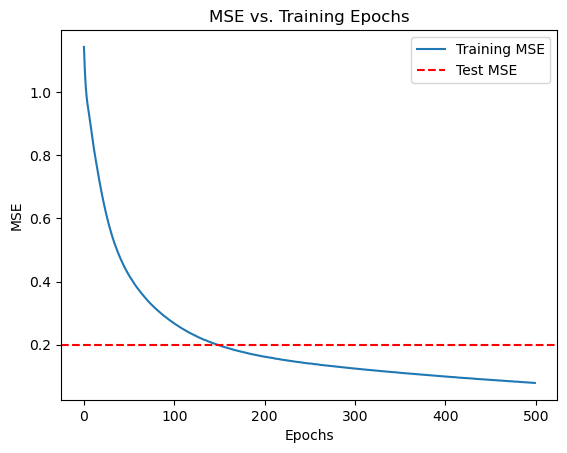

In [820]:
clf_loss = clf.fit(x_train_scaled, y_train).loss_curve_
mse_test = mean_squared_error(y_test, y_pred)

# Plot the MSE over training epochs
plt.plot(clf_loss, label='Training MSE')
plt.axhline(y=mse_test, color='r', linestyle='--', label='Test MSE')
plt.title('MSE vs. Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

## Regression Model for Team Performance